In [313]:
## basic modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # for high resolution displays of plots
fontsize_general = 16
plt.rcParams.update({'font.size': fontsize_general,
                     'axes.titlesize': fontsize_general,
                     'axes.labelsize': fontsize_general,
                     'axes.labelpad': 8,
                     'lines.linewidth': 2,
                     'lines.markersize': 8,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in'})
#import matplotlib as mpl
#mpl.style.use('seaborn-ticks')

######  this is for the pi on the x axis  -----  start
import numpy as np
import matplotlib.pyplot as plt

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))
    
#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
#ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))    
######  this is for the pi on the x axis  ----- end



import scipy.constants as constants # for physical constants

reference: 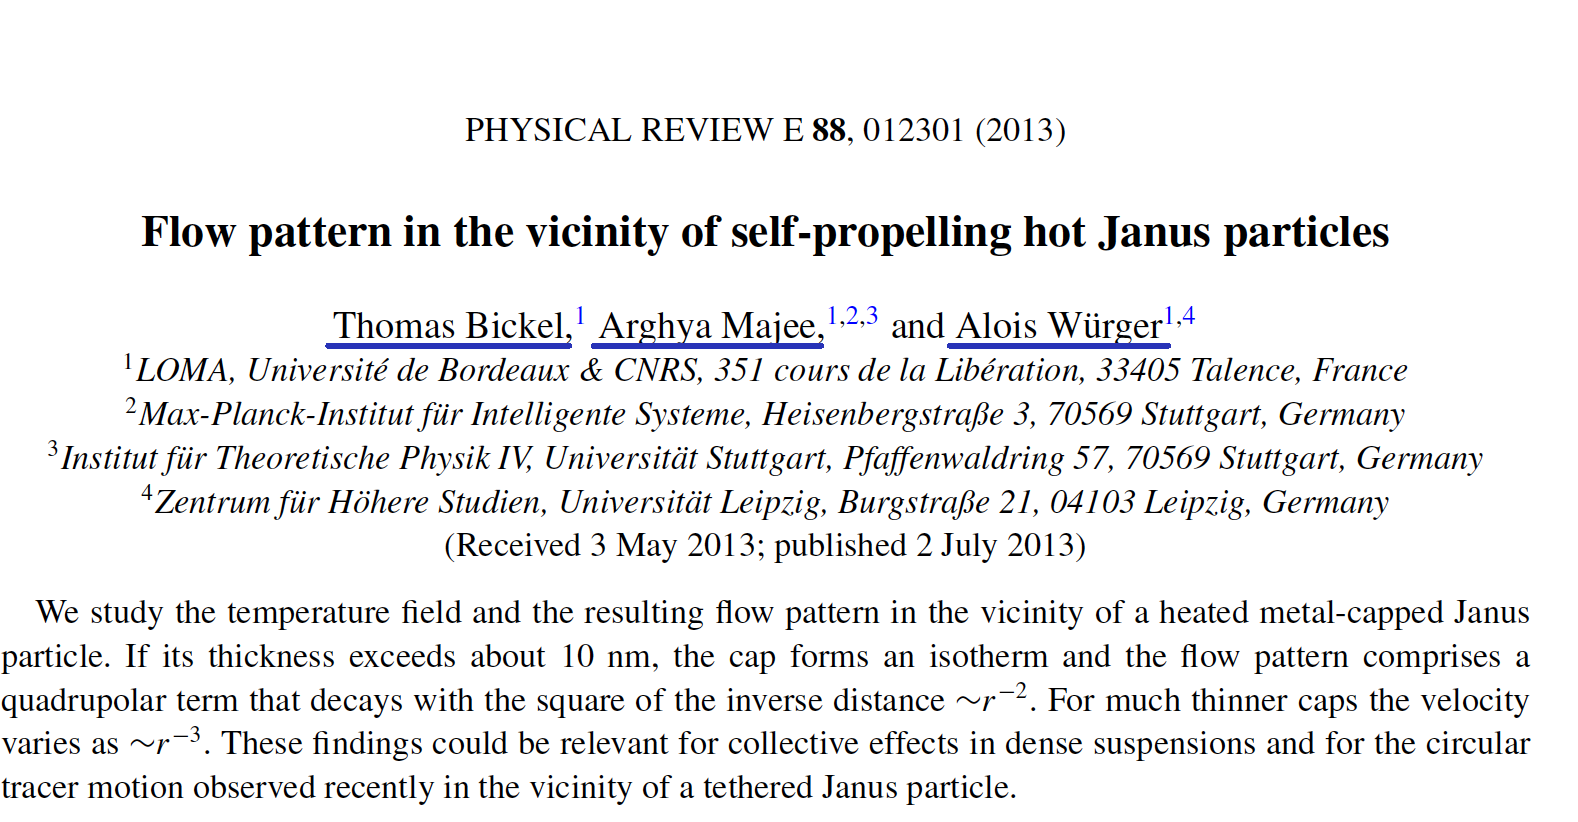


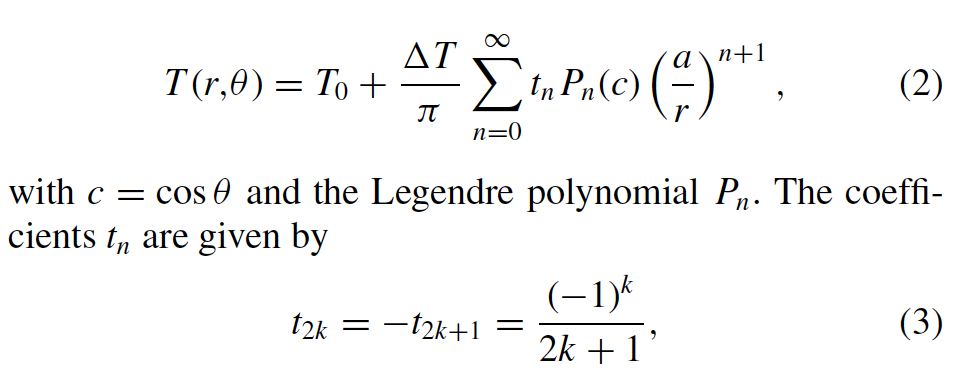

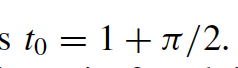


surface creep flow:

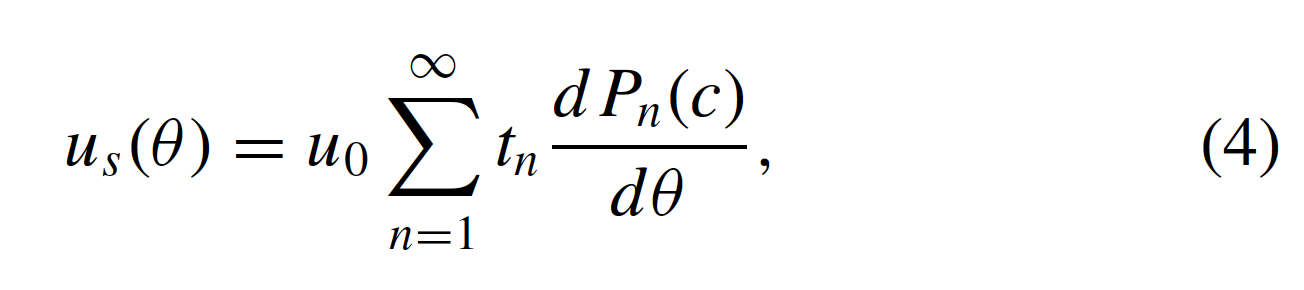

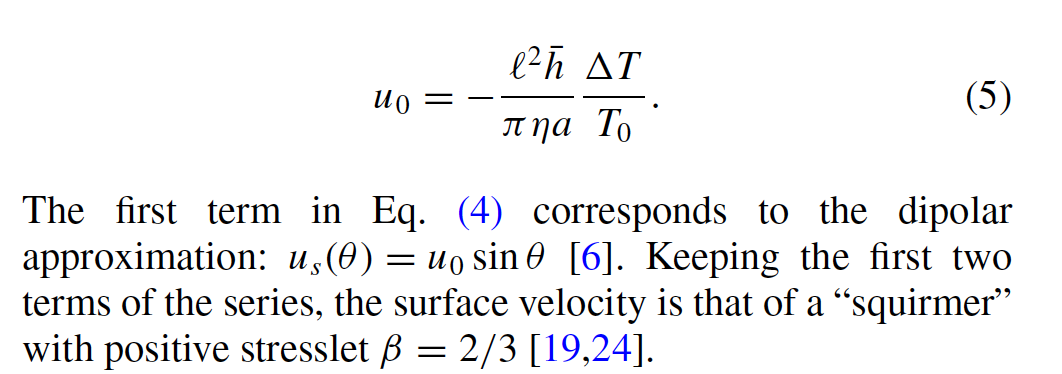

caluclating the derivative of the Legendre polynomial

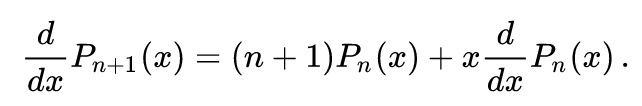

Bulk velocity field:

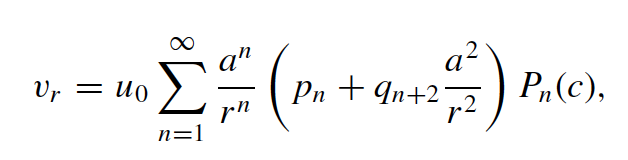

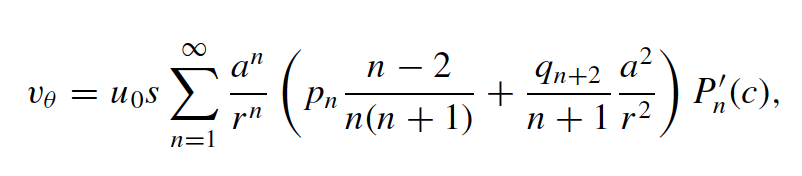

For a fixed particle:

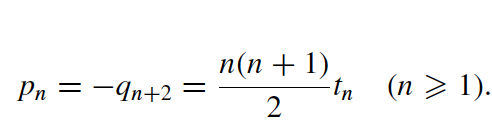

For a moving particle:

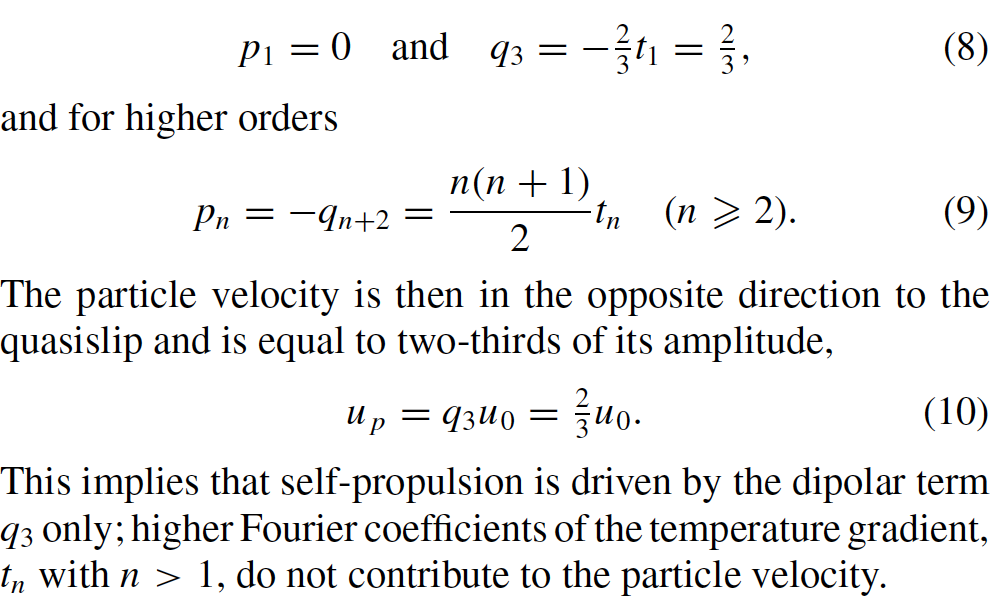



In [314]:
# from scipy.special import eval_legendre
class Fields_Calculator:
    def __init__(self):
        self.Particle_radius = 1e-6 #µm
        
        # for the temperature calcualtion
        self.T_0 = 300 # Kelvin
        self.Delta_T = 1 # Kelvin
        self.n_max = 10
        self.u_0 = 1
    
    def Generate_sum_coefficients(self):
        self.df_coeff = pd.DataFrame({'n': np.arange(0,self.n_max+3,1)}, index = np.arange(0,self.n_max+3,1).astype('int')) # the + 2 is due to the relevane of two more coeff in the v calculation
        
        self.df_coeff.loc[:,['t']] = np.zeros(len(self.df_coeff)) 
        for n in self.df_coeff.n.values:
            if n == 0:
                self.df_coeff.loc[0,['t']] = 1 + np.pi/2
            if n % 2 == 1: # the 2k +1
                self.df_coeff.loc[n,['t']] = - self.df_coeff.loc[n-1,['t']].values
            elif n % 2 == 0: # the 2k 
                self.df_coeff.loc[n,['t']] = (-1)**(n/2) / (n+1)
        self.df_coeff.loc[0,['t']] = 1 + np.pi/2
        # for the velocity calculation
        self.df_coeff.loc[:,['p_fixed']] = np.zeros(len(self.df_coeff))
        self.df_coeff.loc[:,['q_fixed']] = np.zeros(len(self.df_coeff))
        for n in self.df_coeff.n.values:
            self.df_coeff.loc[n,['p_fixed']] = n * (n+1)/2 * self.df_coeff.t[n]
            if n >= 2:
                self.df_coeff.loc[n,['q_fixed']] = -self.df_coeff.loc[n-2,['p_fixed']].values
        self.df_coeff.loc[:,['p_moving']] = self.df_coeff.loc[:,['p_fixed']].values
        self.df_coeff.loc[:,['q_moving']] = self.df_coeff.loc[:,['q_fixed']].values
        self.df_coeff.loc[1,['p_moving']] = 0
        self.df_coeff.loc[3,['q_moving']] = 2/3
        
    
    def Temperature(self,r,theta):
        a = self.Particle_radius
        T_0 = self.T_0
        Delta_T = self.Delta_T
        n_min = 0
        n_max = self.n_max
        mask = self.df_coeff.n <= n_max
        n_list = self.df_coeff.n[mask].values
        t_list = self.df_coeff.t[mask].values
        P_list = np.zeros(len(n_list))
        c = np.cos(theta)
        for i in range(len(P_list)):
            n = n_list[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
        if r > self.Particle_radius:
            T = T_0 + Delta_T/np.pi * np.sum(t_list*P_list*(a/r)**(n_list+1))
        else:
            T = T_0 + Delta_T/np.pi * np.sum(t_list*P_list*(r/a)**(n_list))
        return T
    
    def surface_creep_flow(self,theta):
        u_0 = self.u_0
        n_max = self.n_max
        mask = (self.df_coeff.n <= n_max)
        n_list = self.df_coeff.n[mask].values
        t_list = self.df_coeff.t[mask].values
        P_list = np.zeros(len(n_list))
        P_derivative_list = np.zeros(len(n_list))
        c = np.cos(theta)
        dc_dtheta = - np.sin(theta)
        for i in range(len(P_list)):
            n = n_list[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
            if n > 0:
                P_derivative_list[n] = n*P_list[n-1] + c*P_derivative_list[n-1]
        value = u_0 * np.sum(t_list[1:] * P_derivative_list[1:]) * dc_dtheta
        return value
    
    def velocity_radial(self,r,theta, mode = 'fixed'):
        if r < self.Particle_radius:
            return 0
        a = self.Particle_radius
        v_0 = 1
        n_max = self.n_max
        mask = (self.df_coeff.n <= n_max) & (self.df_coeff.n > 0)
        mask_q = (self.df_coeff.n <= n_max+2) & (self.df_coeff.n > 2)
        n_list = self.df_coeff.n[mask].values
        if mode == 'fixed':
            p_list = self.df_coeff.p_fixed[mask].values
            q_list = self.df_coeff.q_fixed[mask_q].values
        elif mode == 'moving':
            p_list = self.df_coeff.p_moving[mask].values
            q_list = self.df_coeff.q_moving[mask_q].values
        c = np.cos(theta)
        P_list = np.zeros(len(self.df_coeff.n.values))
        for i in range(len(P_list)):
            n = self.df_coeff.n.values[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
        P_list = P_list[1:-2]

        value = v_0 * np.sum( (a/r)**n_list * (p_list + q_list*(a/r)**2) * P_list )
        return value
    
    def velocity_theta(self,r,theta, mode = 'fixed'):
        if r < self.Particle_radius:
            return 0
        a = self.Particle_radius
        v_0 = 1
        n_max = self.n_max
        mask = (self.df_coeff.n <= n_max) & (self.df_coeff.n > 0)
        mask_q = (self.df_coeff.n <= n_max+2) & (self.df_coeff.n > 2)
        n_list = self.df_coeff.n[mask].values
        if mode == 'fixed':
            p_list = self.df_coeff.p_fixed[mask].values
            q_list = self.df_coeff.q_fixed[mask_q].values
        elif mode == 'moving':
            p_list = self.df_coeff.p_moving[mask].values
            q_list = self.df_coeff.q_moving[mask_q].values
        c = np.cos(theta)
        s = np.sin(theta)
        P_list = np.zeros(len(self.df_coeff.n.values))
        P_derivative_list = np.zeros(len(self.df_coeff.n.values))
        for i in range(len(P_list)):
            n = self.df_coeff.n.values[i]
            # Legendre polynomials
            P_list[i] = eval_legendre(n, c)
            if n > 0:
                P_derivative_list[i] = n*P_list[i-1] + c*P_derivative_list[i-1]
        P_list = P_list[1:-2]
        P_derivative_list = P_derivative_list[1:-2]
        value = v_0 * s * np.sum((a/r)**n_list * (p_list*(n_list-2)/(n_list*(n_list+1)) + q_list/(n_list+1)*(a/r)**2)*P_derivative_list)
        return value


# Temperature

In [315]:
Fields = Fields_Calculator()
Fields.n_max = 200
Fields.Generate_sum_coefficients()

In [316]:
r = Fields.Particle_radius
theta_list = np.linspace(0,np.pi,40)
T_list = np.zeros(len(theta_list))
for i in range(len(T_list)):
    T_list[i] = Fields.Temperature(r, theta_list[i])

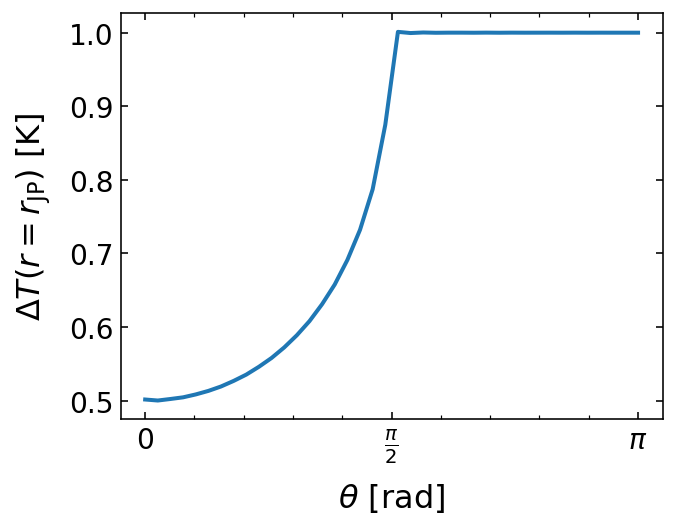

In [317]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(theta_list, T_list - 300)
ax.set_xlabel(r'$\theta$ [rad]')
ax.set_ylabel(r'$\Delta T(r = r_\mathrm{JP})$ [K]')

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))    

plt.tight_layout()
plt.savefig('T_theta_isotherm_cap.pdf')
plt.show()

In [318]:
x_min = -2e-6
x_max = -x_min
N = 100
x_list = np.linspace(x_min, x_max, N)
y_list = np.linspace(x_min, x_max, N)
x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)
r_Matrix = np.sqrt(x_Matrix**2 + y_Matrix**2)
theta_Matrix = np.arctan2(y_Matrix,x_Matrix)
T_Matrix = np.zeros_like(r_Matrix)
for i_y in range(N):
    for j_x in range(N):
        T_Matrix[i_y,j_x] = Fields.Temperature(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x])

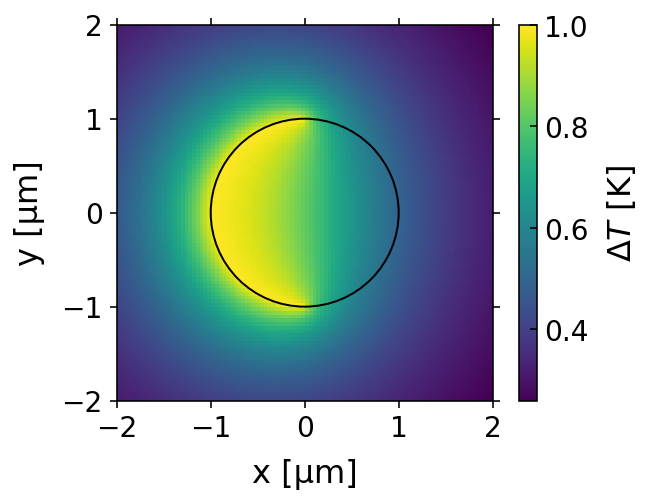

In [319]:

fig, ax1 = plt.subplots(1,1,figsize=(5,5))

im = ax1.imshow(T_Matrix-Fields.T_0, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis')
ax1.set_xlabel('x [µm]')
ax1.set_ylabel('y [µm]')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = r'$\Delta T$ [K]')
circle = plt.Circle((0, 0), Fields.Particle_radius * 1e6, color='k', fill=False)
ax1.add_patch(circle)

ax1.tick_params(direction='out')
#ax1.tick_params(axis="y", direction='out')

plt.tight_layout()
plt.savefig('T_xy_isotherm_cap.pdf')
plt.show()

# velocity

In [320]:
theta_list = np.linspace(0,np.pi,40)

Fields = Fields_Calculator()
Fields.n_max = 1
Fields.Generate_sum_coefficients()
v_surface_list_n1 = np.zeros(len(theta_list))
for i in range(len(T_list)):
    v_surface_list_n1[i] = Fields.surface_creep_flow(theta_list[i])
    
Fields = Fields_Calculator()
Fields.n_max = 2
Fields.Generate_sum_coefficients()
v_surface_list_n2 = np.zeros(len(theta_list))
for i in range(len(T_list)):
    v_surface_list_n2[i] = Fields.surface_creep_flow(theta_list[i])
    
Fields = Fields_Calculator()
Fields.n_max = 5000
Fields.Generate_sum_coefficients()
v_surface_list_n5000 = np.zeros(len(theta_list))
for i in range(len(T_list)):
    v_surface_list_n5000[i] = Fields.surface_creep_flow(theta_list[i])
    

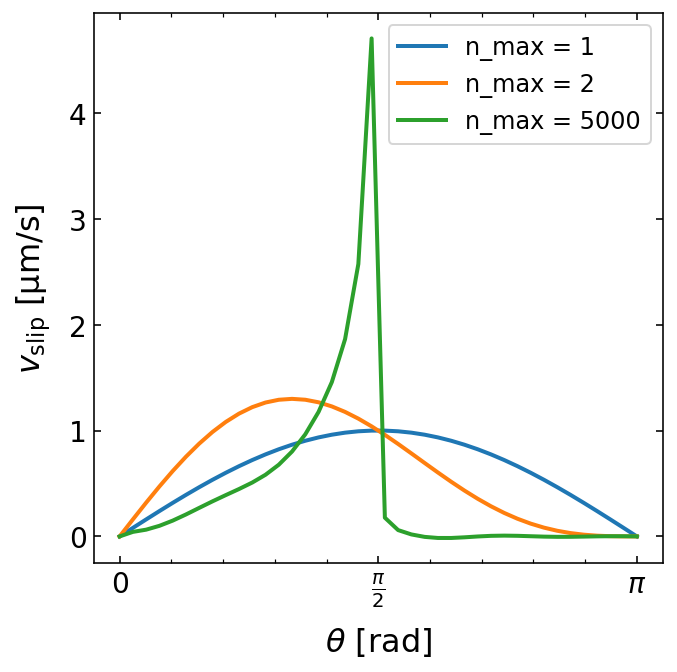

In [321]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(theta_list, v_surface_list_n1, label = 'n_max = 1')
ax.plot(theta_list, v_surface_list_n2, label = 'n_max = 2')
ax.plot(theta_list, v_surface_list_n5000, label = 'n_max = 5000')
ax.set_xlabel(r'$\theta$ [rad]')
ax.set_ylabel(r'$v_\mathrm{slip}$ [µm/s]')

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))    

plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig('slip_flow_theta_vary_n.pdf')
plt.show()

In [322]:
Fields.Particle_radius

1e-06

In [323]:
theta_list = np.linspace(0,np.pi,40)


Fields = Fields_Calculator()
Fields.n_max = 2
Fields.Generate_sum_coefficients()
v_radial = np.zeros(len(theta_list))
v_theta = np.zeros(len(theta_list))
for i in range(len(T_list)):
    v_radial[i] = Fields.velocity_radial(Fields.Particle_radius,theta_list[i], mode = 'fixed')
    v_theta[i] = Fields.velocity_theta(Fields.Particle_radius,theta_list[i], mode = 'fixed')

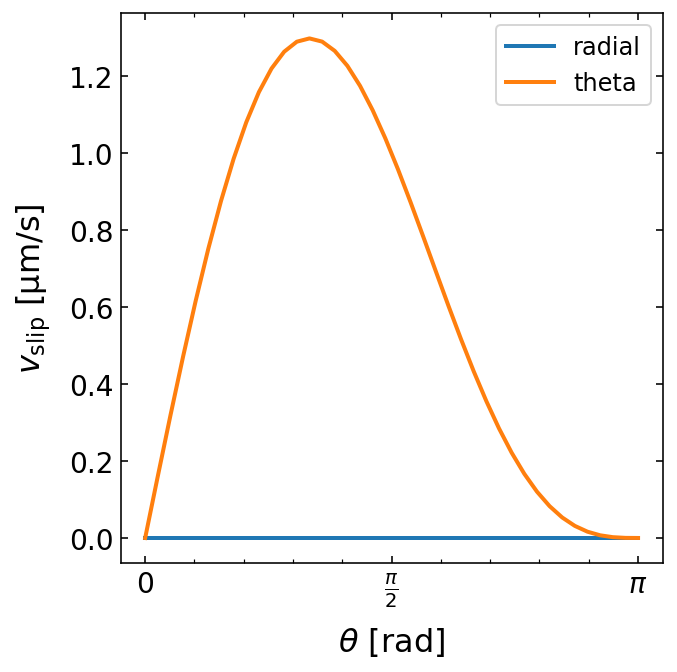

In [324]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(theta_list, v_radial, label = 'radial')
ax.plot(theta_list, v_theta, label = 'theta')
ax.set_xlabel(r'$\theta$ [rad]')
ax.set_ylabel(r'$v_\mathrm{slip}$ [µm/s]')

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 10))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))    

plt.legend(fontsize = 12)
plt.tight_layout()
#plt.savefig('slip_flow_theta_vary_n.pdf')
plt.show()

In [366]:
Fields = Fields_Calculator()
Fields.n_max = 100
Fields.Generate_sum_coefficients()

In [367]:

x_min = -2e-6
x_max = -x_min
N = 10
x_list = np.linspace(x_min, x_max, N)
y_list = np.linspace(x_min, x_max, N)
x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)
r_Matrix = np.sqrt(x_Matrix**2 + y_Matrix**2)
theta_Matrix = np.arctan2(y_Matrix,x_Matrix)
v_radial_Matrix = np.zeros_like(r_Matrix)
v_theta_Matrix = np.zeros_like(r_Matrix)
for i_y in range(N):
    for j_x in range(N):
        v_radial_Matrix[i_y,j_x] = Fields.velocity_radial(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
        v_theta_Matrix[i_y,j_x] = Fields.velocity_theta(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')

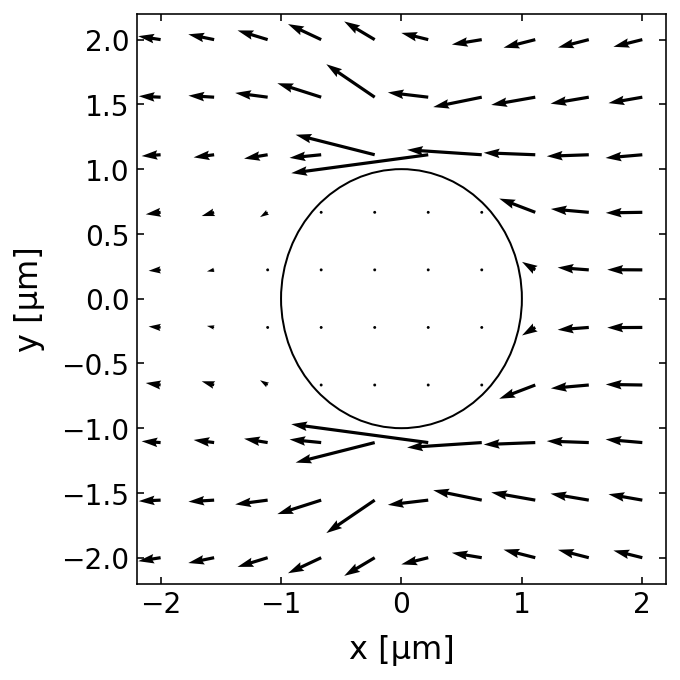

In [368]:
u_p = 2/3 * Fields.u_0


fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

v_x_Matrix = v_radial_Matrix * np.cos(theta_Matrix) - v_theta_Matrix * np.sin(theta_Matrix)
v_y_Matrix = v_radial_Matrix * np.sin(theta_Matrix) + v_theta_Matrix * np.cos(theta_Matrix)

Q = ax.quiver(x_Matrix*1e6, y_Matrix*1e6, v_x_Matrix, v_y_Matrix)
#qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'[µm/s]', labelpos='E',
#                   coordinates='figure')
#im = ax1.imshow(v_theta_Matrix, extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis')

## create an axes on the right side of ax. The width of cax will be 5%
## of ax and the padding between cax and ax will be fixed at 0.18 inch.
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.18)
#cbar = plt.colorbar(im, cax=cax, label = 'v theta [µm/s]')

circle = plt.Circle((0, 0), Fields.Particle_radius * 1e6, color='k', fill=False)
ax.add_patch(circle)

plt.tight_layout()
plt.savefig('moving_JP_fluid_flow_field_quiver_xy.pdf')
plt.show()


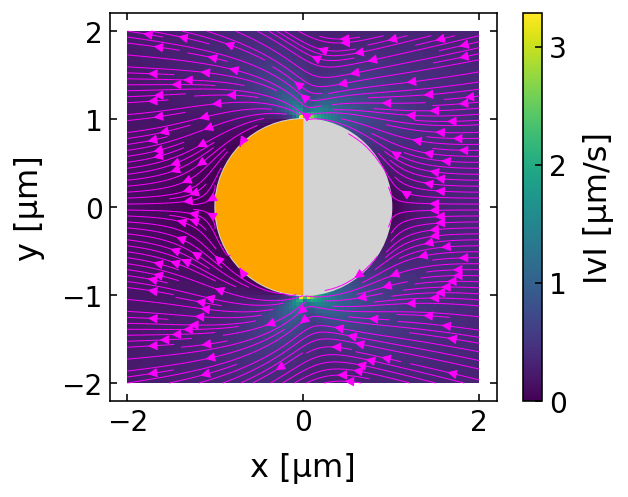

In [386]:

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

v_x_Matrix = v_radial_Matrix * np.cos(theta_Matrix) - v_theta_Matrix * np.sin(theta_Matrix)
v_y_Matrix = v_radial_Matrix * np.sin(theta_Matrix) + v_theta_Matrix * np.cos(theta_Matrix)
#Q = ax.quiver(x_Matrix, y_Matrix, v_x_Matrix, v_y_Matrix)
S = ax.streamplot(x_Matrix*1e6, y_Matrix*1e6, v_x_Matrix, v_y_Matrix, density=[2, 2],color = 'magenta', linewidth = 0.5)

ax.set_xlim((np.min(x_Matrix)*1.1*1e6,np.max(x_Matrix)*1.1*1e6))
ax.set_ylim((np.min(y_Matrix)*1.1*1e6,np.max(y_Matrix)*1.1*1e6))

im = ax.imshow(np.sqrt(v_theta_Matrix**2+v_radial_Matrix**2), extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')

circle = plt.Circle((0, 0), Fields.Particle_radius*1e6, color='lightgrey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.Particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)

plt.tight_layout()
plt.savefig('moving_JP_fluid_flow_field_streamline_mag_xy.pdf')
plt.show()

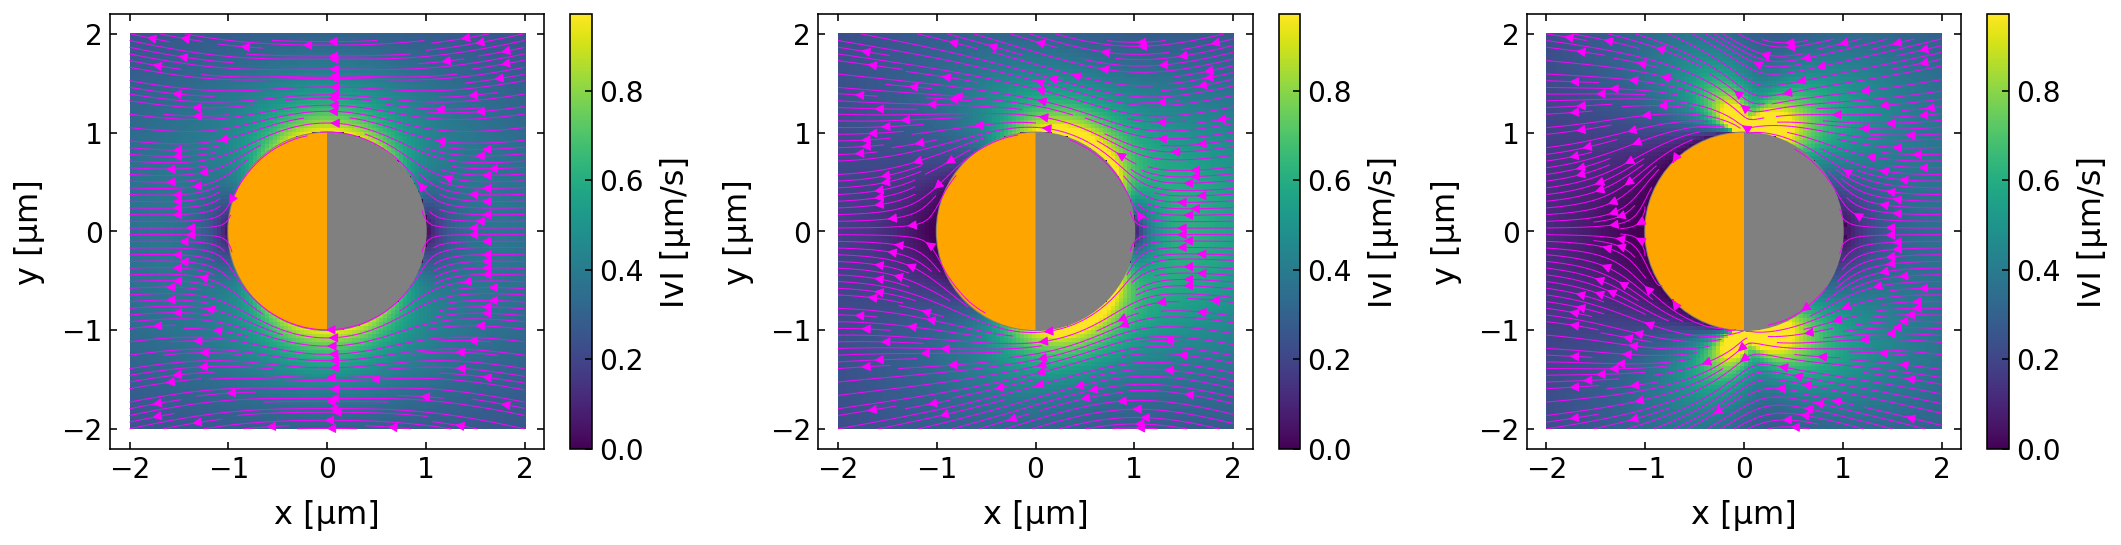

In [389]:
fig, Ax = plt.subplots(1,3, figsize = (3*5,5))
ax1, ax2, ax3 = Ax

ax = ax1
Fields = Fields_Calculator()
Fields.n_max = 1
Fields.Generate_sum_coefficients()
x_min = -2e-6
x_max = -x_min
N = 100
x_list = np.linspace(x_min, x_max, N)
y_list = np.linspace(x_min, x_max, N)
x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)
r_Matrix = np.sqrt(x_Matrix**2 + y_Matrix**2)
theta_Matrix = np.arctan2(y_Matrix,x_Matrix)
v_radial_Matrix = np.zeros_like(r_Matrix)
v_theta_Matrix = np.zeros_like(r_Matrix)
for i_y in range(N):
    for j_x in range(N):
        v_radial_Matrix[i_y,j_x] = Fields.velocity_radial(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
        v_theta_Matrix[i_y,j_x] = Fields.velocity_theta(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
im = ax.imshow(np.sqrt(v_theta_Matrix**2+v_radial_Matrix**2), extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0)
vmax = np.max(np.sqrt(v_theta_Matrix**2+v_radial_Matrix**2))
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')
v_x_Matrix = v_radial_Matrix * np.cos(theta_Matrix) - v_theta_Matrix * np.sin(theta_Matrix)
v_y_Matrix = v_radial_Matrix * np.sin(theta_Matrix) + v_theta_Matrix * np.cos(theta_Matrix)
S = ax.streamplot(x_Matrix*1e6, y_Matrix*1e6, v_x_Matrix, v_y_Matrix, density=[2, 2],color = 'magenta', linewidth = 0.5)
ax.set_xlim((np.min(x_Matrix)*1.1*1e6,np.max(x_Matrix)*1.1*1e6))
ax.set_ylim((np.min(y_Matrix)*1.1*1e6,np.max(y_Matrix)*1.1*1e6))
circle = plt.Circle((0, 0), Fields.Particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.Particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)


ax = ax2
Fields = Fields_Calculator()
Fields.n_max = 2
Fields.Generate_sum_coefficients()
x_min = -2e-6
x_max = -x_min
N = 100
x_list = np.linspace(x_min, x_max, N)
y_list = np.linspace(x_min, x_max, N)
x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)
r_Matrix = np.sqrt(x_Matrix**2 + y_Matrix**2)
theta_Matrix = np.arctan2(y_Matrix,x_Matrix)
v_radial_Matrix = np.zeros_like(r_Matrix)
v_theta_Matrix = np.zeros_like(r_Matrix)
for i_y in range(N):
    for j_x in range(N):
        v_radial_Matrix[i_y,j_x] = Fields.velocity_radial(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
        v_theta_Matrix[i_y,j_x] = Fields.velocity_theta(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
im = ax.imshow(np.sqrt(v_theta_Matrix**2+v_radial_Matrix**2), extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0, vmax = vmax)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')
v_x_Matrix = v_radial_Matrix * np.cos(theta_Matrix) - v_theta_Matrix * np.sin(theta_Matrix)
v_y_Matrix = v_radial_Matrix * np.sin(theta_Matrix) + v_theta_Matrix * np.cos(theta_Matrix)
#Q = ax.quiver(x_Matrix, y_Matrix, v_x_Matrix, v_y_Matrix)
S = ax.streamplot(x_Matrix*1e6, y_Matrix*1e6, v_x_Matrix, v_y_Matrix, density=[2, 2],color = 'magenta', linewidth = 0.5)
ax.set_xlim((np.min(x_Matrix)*1.1*1e6,np.max(x_Matrix)*1.1*1e6))
ax.set_ylim((np.min(y_Matrix)*1.1*1e6,np.max(y_Matrix)*1.1*1e6))
circle = plt.Circle((0, 0), Fields.Particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.Particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)


ax = ax3
Fields = Fields_Calculator()
Fields.n_max = 100
Fields.Generate_sum_coefficients()
x_min = -2e-6
x_max = -x_min
N = 100
x_list = np.linspace(x_min, x_max, N)
y_list = np.linspace(x_min, x_max, N)
x_Matrix, y_Matrix = np.meshgrid(x_list, y_list)
r_Matrix = np.sqrt(x_Matrix**2 + y_Matrix**2)
theta_Matrix = np.arctan2(y_Matrix,x_Matrix)
v_radial_Matrix = np.zeros_like(r_Matrix)
v_theta_Matrix = np.zeros_like(r_Matrix)
for i_y in range(N):
    for j_x in range(N):
        v_radial_Matrix[i_y,j_x] = Fields.velocity_radial(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
        v_theta_Matrix[i_y,j_x] = Fields.velocity_theta(r_Matrix[i_y,j_x], theta_Matrix[i_y,j_x], mode = 'fixed')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
im = ax.imshow(np.sqrt(v_theta_Matrix**2+v_radial_Matrix**2), extent=[x_min*1e6,x_max*1e6,x_min*1e6,x_max*1e6], cmap = 'viridis', zorder = 0, vmax = vmax)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.18 inch.
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)
cbar = plt.colorbar(im, cax=cax, label = 'IvI [µm/s]')
v_x_Matrix = v_radial_Matrix * np.cos(theta_Matrix) - v_theta_Matrix * np.sin(theta_Matrix)
v_y_Matrix = v_radial_Matrix * np.sin(theta_Matrix) + v_theta_Matrix * np.cos(theta_Matrix)
#Q = ax.quiver(x_Matrix, y_Matrix, v_x_Matrix, v_y_Matrix)
S = ax.streamplot(x_Matrix*1e6, y_Matrix*1e6, v_x_Matrix, v_y_Matrix, density=[2, 2],color = 'magenta', linewidth = 0.5)
ax.set_xlim((np.min(x_Matrix)*1.1*1e6,np.max(x_Matrix)*1.1*1e6))
ax.set_ylim((np.min(y_Matrix)*1.1*1e6,np.max(y_Matrix)*1.1*1e6))
circle = plt.Circle((0, 0), Fields.Particle_radius*1e6, color='grey', fill=True)
ax.add_patch(circle)
from matplotlib.patches import Wedge
wedge = Wedge((0, 0), Fields.Particle_radius*1e6, 90, 90 + 180, fc='orange')
ax.add_patch(wedge)


plt.tight_layout()
plt.savefig('moving_JP_fluid_flow_field_streamline_mag_xy_n1_2_100.pdf')
plt.show()